<a href="https://colab.research.google.com/github/AshishGusain17/multiple-houusehold-objects-classification/blob/master/changes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
# inception_v3.InceptionV3
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.resnet import ResNet50
# from keras.applications.resnet import ResNet50

from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [0]:
import h5py
dataset = h5py.File('/content/drive/My Drive/room.h5', "r")

X = dataset["X"][:]
Z = dataset["Z"][:]
name = dataset["name"][:]
print(X.shape,Z.shape,name.shape)

(1587, 150, 150, 3) (1587,) (1587,)


In [0]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
# Y = to_categorical(Y,25)
Z = to_categorical(Z,14)
# X = np.array(X)
X = X/255

x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)

(1269, 150, 150, 3) (1269, 14)


In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

1587


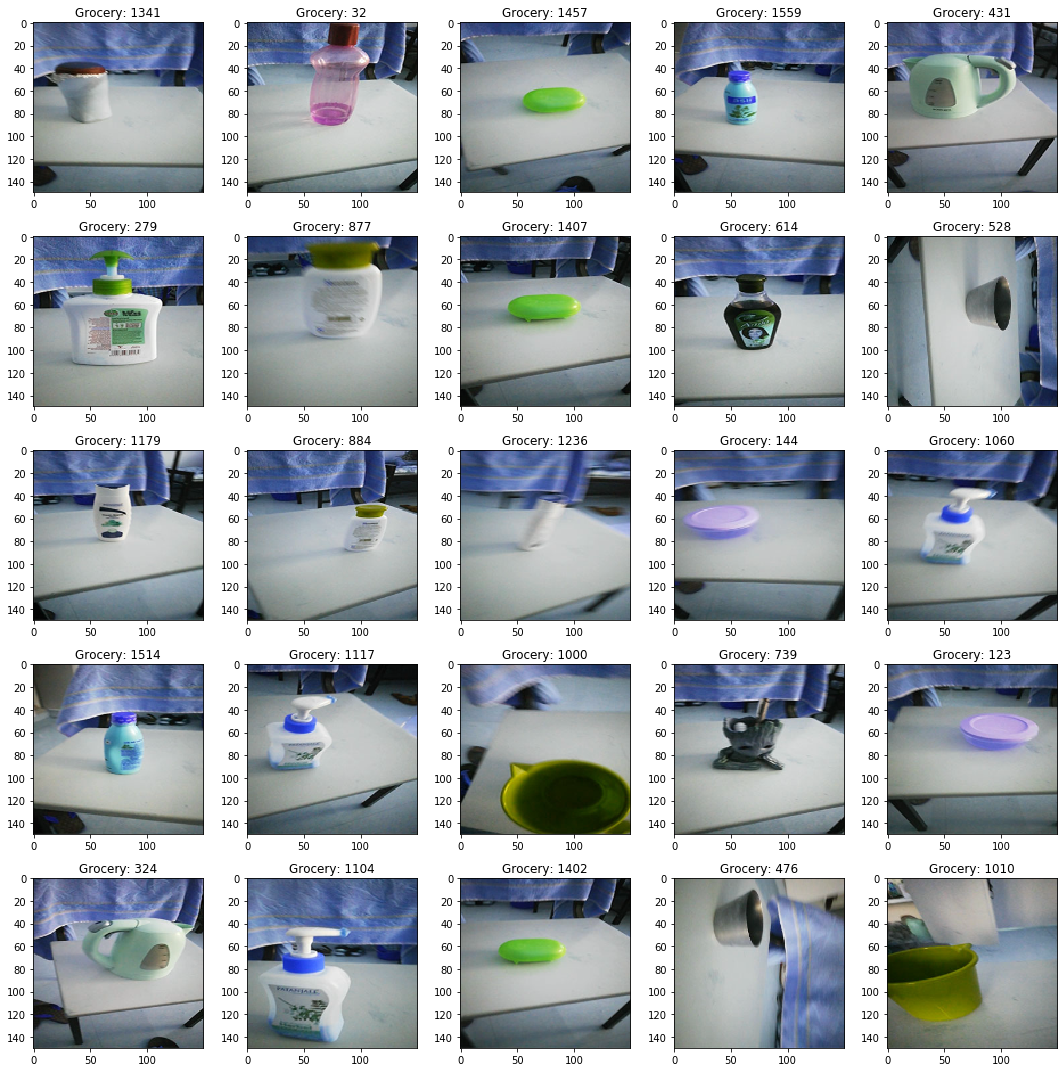

In [0]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Grocery: '+ str(l))
        
plt.tight_layout()

<keras.engine.input_layer.InputLayer object at 0x7f48b05a6eb8> True
<keras.layers.convolutional.Conv2D object at 0x7f48b05a62b0> True
<keras.layers.convolutional.Conv2D object at 0x7f48b05a6160> True
<keras.layers.pooling.MaxPooling2D object at 0x7f48b05cb6d8> True
<keras.layers.convolutional.Conv2D object at 0x7f48b0589780> True
<keras.layers.convolutional.Conv2D object at 0x7f48b05fc0f0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f48b05c3cc0> True
<keras.layers.convolutional.Conv2D object at 0x7f48b06095f8> True
<keras.layers.convolutional.Conv2D object at 0x7f48b0590780> True
<keras.layers.convolutional.Conv2D object at 0x7f48b0a6fa58> True
<keras.layers.pooling.MaxPooling2D object at 0x7f48b0853b38> True
<keras.layers.convolutional.Conv2D object at 0x7f48b080fa90> True
<keras.layers.convolutional.Conv2D object at 0x7f48b08113c8> True
<keras.layers.convolutional.Conv2D object at 0x7f48b0809d68> True
<keras.layers.pooling.MaxPooling2D object at 0x7f48b0816630> True
<keras.l

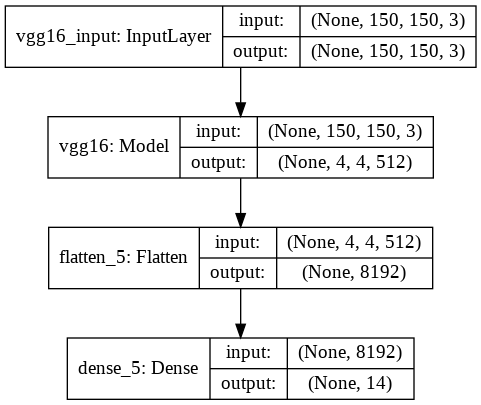

In [0]:
imgsize,ct=150,0
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
for layer in base_model.layers:
    ct=ct+1

for layer in base_model.layers:
    # if ct>4:
    #   layer.trainable = False
    # else:
    #   layer.trainable = True
    # ct=ct-1
    layer.trainable = True

for layer in base_model.layers:
    print(layer,layer.trainable)
    # pass
model = Sequential()
model.add(base_model)
model.add(Flatten())
# model.add(Dropout(0.3))
# model.add(regularizers.l2(0.01))
# model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.06)))

model.add(Dense(14,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]
# callbacks = [earlystop,tensorboard,csvlogger,reduce]

In [0]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)

history = model.fit(
    x_train,y_train,batch_size=128,
    validation_data  = (x_test,y_test),
    # validation_steps = 100,
    # steps_per_epoch  = 10,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Train on 1269 samples, validate on 318 samples
Epoch 1/20
1269/1269 [==============================] - 6s 4ms/step - loss: 3.7015 - acc: 0.0883 - val_loss: 2.6194 - val_acc: 0.0912

Epoch 00001: val_acc improved from -inf to 0.09119, saving model to ./base.model
Epoch 2/20
1269/1269 [==============================] - 5s 4ms/step - loss: 2.6378 - acc: 0.0906 - val_loss: 2.6101 - val_acc: 0.1101

Epoch 00002: val_acc improved from 0.09119 to 0.11006, saving model to ./base.model
Epoch 3/20
1269/1269 [==============================] - 5s 4ms/step - loss: 2.6268 - acc: 0.0867 - val_loss: 2.6018 - val_acc: 0.1226

Epoch 00003: val_acc improved from 0.11006 to 0.12264, saving model to ./base.model
Epoch 4/20
1269/1269 [==============================] - 5s 4ms/step - loss: 2.6040 - acc: 0.1127 - val_loss: 2.5361 - val_acc: 0.2201

Epoch 00004: val_acc improved from 0.12264 to 0.22013, saving model to ./base.model
Epoch 5/20
1269/1269 [==============================] - 5s 4ms/step - loss: 2.45

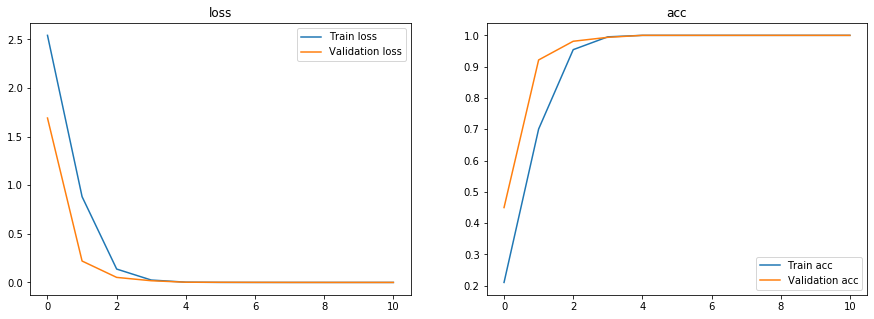

In [0]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [0]:
model.evaluate(x_test,y_test)

318/318 [==============================] - 1s 4ms/step


[0.0003076343544410709, 1.0]

In [0]:
model.evaluate(x_train,y_train)

1269/1269 [==============================] - 2s 2ms/step


[3.27727421963494e-05, 1.0]